# LSTM

### Libraries

1. Let's import the usual libraries:

In [29]:
# Data manipulation
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

# Data Visualiation
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os

# Deep Learning
import tensorflow as tf

2. Manipulating temporal data is tricky, let's also import 📚 [`typing`](https://docs.python.org/3/library/typing.html) to check the types of variables we will be dealing with in our Python functions:

In [30]:
from typing import Dict, List, Tuple, Sequence

# (0) The LSTM inflation forecasting

## (0.0) Introduction

### Load data

In [31]:
df = pd.read_csv('data.csv')
df

,Unnamed: 0,Time,DFF,CPIAUCSL,CPILFESL,UNRATE,WTISPLC,INDPRO,MABMM301USM189S,A576RC1
0,0,1960-01-01,3.99,1.24095,2.00669,5.2,2.97,10.03675,NaN,7.05509
1,1,1960-02-01,3.97,1.41379,2.34114,4.8,2.97,6.96284,NaN,6.78233
2,2,1960-03-01,3.84,1.51881,2.00000,5.4,2.97,4.49722,NaN,5.93518
3,3,1960-04-01,3.92,1.93237,2.00000,5.2,2.97,1.50636,NaN,5.56845
4,4,1960-05-01,3.85,1.82507,1.66113,5.1,2.97,-0.11438,NaN,4.94632
...,...,...,...,...,...,...,...,...,...,...
752,752,2022-09-01,2.56,8.21485,6.64296,3.5,84.26,4.73131,2.56370,9.07203
753,753,2022-10-01,3.08,7.76249,6.30176,3.7,87.55,3.18912,1.28501,8.07029
754,754,2022-11-01,3.78,7.13535,5.97198,3.6,84.37,1.98468,0.02623,7.43424
755,755,2022-12-01,4.10,6.44494,5.70386,3.5,76.44,1.14673,-1.31457,6.94998


In [32]:
df = df.drop('Unnamed: 0', axis=1)

In [33]:
df = df.drop('Time', axis=1)

In [34]:
df = df.iloc[12:]

In [35]:
# Let's define the global variables of our dataset
TARGET = 'CPILFESL'
N_TARGETS = 1
N_FEATURES = 7

### (0.0.2) Visualising your Time Series

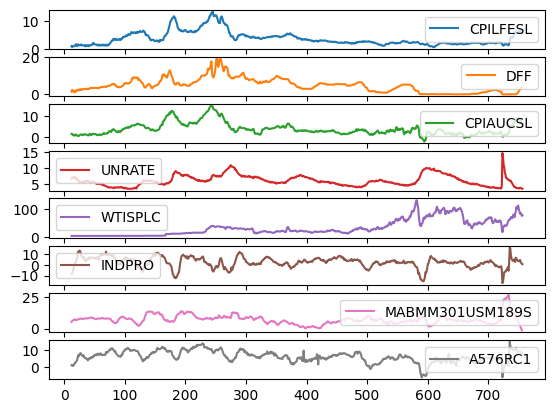

In [36]:
plot_cols = [TARGET, 'DFF', 'CPIAUCSL','UNRATE','WTISPLC','INDPRO','MABMM301USM189S','A576RC1']
plot_features = df[plot_cols]
plot_features.index = df.index
plot_features.plot(subplots = True);

# (1) Prepare the dataset

##  (1.0) The big picture

## (1.1) 💻 Creating  <font color="#c91ac9">**FOLDS**</font> for cross-validation

Each of them with shape `(FOLD_LENGTH, n_features)` 

🌐 Let's define some global variables that we will use for our tests everywhere in this notebook:

In [37]:
# --------------------------------------------------- #
# Let's consider FOLDS with a length of 3 years       #
# (2 years will be used for train, 1 for test!)       #
# --------------------------------------------------- #

FOLD_LENGTH = 12*10     # every month x * 10
                        # sixtee years

# --------------------------------------------------- #
# Let's consider FOLDS starting every quarter       #
# --------------------------------------------------- #
    
FOLD_STRIDE = int((12*10)/3) # every 3 hrs x 8 = 24h
                         # 1 quarter = 4 month

# --------------------------------------------------- #
# Let's consider a train-test-split ratio of 2/3      #
# --------------------------------------------------- #

TRAIN_TEST_RATIO = 0.8

💻 ❓ **Question (<font color="#c91ac9">FOLDS</font>)** ❓

Code the function `get_folds` below that we will use to create folds  `folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)`

In [38]:
def get_folds(
    df: pd.DataFrame,
    fold_length: float,
    fold_stride: float) -> List[pd.DataFrame]:
    '''
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold
    
    Returns a list of folds, each as a DataFrame
    '''
    
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds

In [39]:
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f'The function generated {len(folds)} folds.')
print(f'Each fold has a shape equal to {folds[0].shape}.')

The function generated 16 folds.
Each fold has a shape equal to (120, 8).


☝️ This amount of <font color="#c91ac9">**FOLDS**</font> should be enough to cross-validate our model correctly !

## (1.2) 💻 Temporal <font color=blue>**Train**</font>/<font color="#ff8005">**Test**</font> Split

👩🏻‍🏫 Let's focus on one fold for the moment.

In [40]:
fold = folds[0]
fold

,DFF,CPIAUCSL,CPILFESL,UNRATE,WTISPLC,INDPRO,MABMM301USM189S,A576RC1
12,1.45,1.60027,0.98361,6.6,2.97,-8.45377,5.33199,1.22177
13,2.54,1.46209,0.65359,6.9,2.97,-7.74411,6.06568,0.96012
14,2.02,1.46209,0.98039,6.9,2.97,-6.34204,6.34815,1.17951
15,1.49,0.91401,0.98039,7.0,2.97,-3.65304,6.59780,0.91575
16,1.98,0.91309,0.98039,7.1,2.97,-2.05700,7.07876,1.35185
...,...,...,...,...,...,...,...,...
127,6.62,5.69106,6.20155,5.1,3.31,-3.83016,4.27512,5.65680
128,6.29,5.66038,6.16967,5.4,3.31,-4.47156,4.99914,4.75024
129,6.20,5.63003,6.13811,5.5,3.31,-6.40969,5.65650,3.86202
130,5.60,5.60000,6.63265,5.9,3.31,-6.09146,6.09839,3.48620


☝️ We want to split this fold **chronologically** into:

- a <font color=blue>train</font> dataframe
- a <font color="#ff8005">test</font> dataframe

that will contain all the data we need to be able to sample many `(X_i, y_i)` pairs in each dataframe in a next step! 

The `INPUT_LENGTH` of each `X_i` is going to be equal to 2 weeks (it is quite a common period for weather forecasting)

In [41]:
INPUT_LENGTH = 30

💻 ❓ **Question (temporal <font color=blue>train</font>-<font color=orange>test</font> split)** ❓

Code the function `train_test_split` down below which:
- <i>(input)</i> given a `fold` (like above), a `train_test_ratio` (e.g 0.8) and an `input_length` (fixed)
- <i>(output)</i> a tuple of (`fold_train`, `fold_test`) dataframes


<details>
    <summary><i>Hints to avoid data leakage</i></summary>

- `fold_train` last index will become the last `y_train` later on
- `fold_test` first index will be used to create the first `X_test`
- To avoid data leakage, `y_train_last` should be JUST before `y_test_first`

<img src="https://github.com/lewagon/data-images/blob/master/DL/explanations_for_train_test_split_temporal.png?raw=true" alt="train_test_split_temporal" width="500" height="500"> 
    
</details>    

In [42]:
def train_test_split(fold:pd.DataFrame,
                     train_test_ratio: float,
                     input_length: int) -> Tuple[pd.DataFrame]:
    '''
    Returns a train dataframe and a test dataframe (fold_train, fold_test)
    from which one can sample (X,y) sequences.
    df_train should contain all the timesteps until round(train_test_ratio * len(fold))   
    '''
    
    # TRAIN SET
    # ======================
    last_train_idx = round(train_test_ratio * len(fold))
    fold_train = fold.iloc[0:last_train_idx, :]

    # TEST SET
    # ======================    
    first_test_idx = last_train_idx - input_length
    fold_test = fold.iloc[first_test_idx:, :]

    return (fold_train, fold_test)

In [43]:
(fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)

## (1.3) 💻 Create (X, y) sequences

In [44]:
# TARGET Y
print(f'N_TARGETS = {N_TARGETS}')

# Let's only predict 1 value ahead of us
OUTPUT_LENGTH = 1
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')

N_TARGETS = 1
OUTPUT_LENGTH = 1


### (1.2.1) 💻 Option 1: Create (X, y) by random sampling in each split

#### (1.2.2.1) 💻 Generating one random sequence

<img src="https://github.com/lewagon/data-images/blob/master/DL/get_xi_yi.png?raw=true" alt="one sequence" width="400" height="400"> 

💻 ❓ **Question (extracting a random sequence from a fold)** ❓

Code the function `get_Xi_yi` down below which:
- <i>(input)</i> given a fold, an `input_length` and an `output_length`
- <i>(output)</i> returns a sequence $(X_i,y_i)$

In [45]:
def get_Xi_yi(
    fold:pd.DataFrame, 
    input_length:int, 
    output_length:int):
    '''
    - given a fold, it returns one sequence (X_i, y_i)
    - with the starting point of the sequence being chosen at random
    '''
    first_possible_start = 0
    last_possible_start = len(fold) - (input_length + output_length) + 1
    random_start = np.random.randint(first_possible_start, last_possible_start)
    X_i = fold.iloc[random_start:random_start+input_length]    
    y_i = fold.iloc[random_start+input_length:
                  random_start+input_length+output_length][[TARGET]]
    
    return (X_i, y_i)

In [46]:
X_train_i, y_train_i = get_Xi_yi(fold_train, INPUT_LENGTH, OUTPUT_LENGTH)
X_test_i, y_test_i = get_Xi_yi(fold_test, INPUT_LENGTH, OUTPUT_LENGTH)

#### (1.2.2.2) 💻 Generating multiple random sequences

<img src="https://bit.ly/3Ri8Vfd" alt="Sequences in each fold" width="500" height="500"> 

💻 ❓ **Question (extracting multiple random sequence from a fold)** ❓

Code the function `get_X_y` down below which:
- <i>(input)</i> given a fold, a `number_of_sequences` an `input_length` and an `output_length`
- <i>(output)</i> returns $(X,y)$ 

_Don't forget to use the `get_Xi_yi` function that you have just coded!_

In [48]:
def get_X_y(
    fold:pd.DataFrame,
    number_of_sequences:int,
    input_length:int,
    output_length:int
):
   
    X, y = [], []

    for i in range(number_of_sequences):
        (Xi, yi) = get_Xi_yi(fold, input_length, output_length)
        X.append(Xi)
        y.append(yi)
        
    return np.array(X), np.array(y)


In [49]:
N_TRAIN = 80 # number_of_sequences_train
N_TEST =  20 # number_of_sequences_test

X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)

### (1.2.2) (Don't read this now, keep for later) 🎁 Option 2: Scanning  chronologically

As stated earlier, there are multiple ways to extract sequences from a fold. 

- 🎲 In the previous section, you coded:
    - `get_Xi_yi` which randomly samples _one_ sequence 
    - and `get_X_y` which randomly generates _multiple_ sequences

- ⌚️ In this section, we provide you a unique function `get_X_y_strides`.
    - It scans a fold chronologically based on:
         - an `input_length` (let's still use `INPUT_LENGTH = 8 * 14`, i.e. two weeks) 
         - and a `sequence_stride` (think about a one-dimensional convolutional operation!)

In [50]:
SEQUENCE_STRIDE = 1

In [51]:
def get_X_y_strides(fold: pd.DataFrame, input_length: int, output_length: int, sequence_stride: int):
    '''
    - slides through a `fold` Time Series (2D array) to create sequences of equal
        * `input_length` for X,
        * `output_length` for y,
    using a temporal gap `sequence_stride` between each sequence
    - returns a list of sequences, each as a 2D-array time series
    '''

    X, y = [], []

    for i in range(0, len(fold), sequence_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (i + input_length + output_length) >= len(fold):
            break
        X_i = fold.iloc[i:i + input_length, :]
        y_i = fold.iloc[i + input_length:i + input_length + output_length, :][[TARGET]]
        X.append(X_i)
        y.append(y_i)

    return np.array(X), np.array(y)

In [52]:
print("FOLD_LENGTH") 
print(f"= {FOLD_LENGTH} timesteps")
print(f"= {int(FOLD_LENGTH/12)} months")

FOLD_LENGTH
= 120 timesteps
= 10 months


In [53]:
X_train, y_train = get_X_y_strides(fold_train, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)
X_test, y_test = get_X_y_strides(fold_test, INPUT_LENGTH, OUTPUT_LENGTH, SEQUENCE_STRIDE)

print(X_train.shape)
print(y_train.shape)

(65, 30, 8)
(65, 1, 1)


# (2) 💻 Modelling

**The MSE as a metrics to monitor the temperature prediction**

The Mean Standard Error seems to be a reasonable metrics to evaluate a model's capability to predict the inflation:

$$ MSE $$

## (2.1) 💻 A Recurrent Neural Network: the `LSTM`

🚀 It is time to design a Recurrent Neural Network and hopefully beat the baseline 💪 !

💻 ❓ **Question (RNN)** ❓ 

- Create a function `init_model` which builds and compiles a simple Recurrent Neural Network with an LSTM layer
- Don't forget to normalize your data with a [📚 Normalization layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Normalization)

In [68]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.layers.experimental.preprocessing import Normalization

def init_model(X_train, y_train):
      
    
    # 0 - Normalization
    # ======================    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    # 1 - RNN architecture
    # ======================    
    model = models.Sequential()
    ## 1.0 - All the rows will be standardized through the already adapted normalization layer
    model.add(normalizer)
    ## 1.1 - Recurrent Layer
    model.add(layers.LSTM(64, 
                          activation='tanh', 
                          return_sequences = False,
                          kernel_regularizer=L1L2(l1=0.05, l2=0.05),
                          ))
    ## 1.2 - Predictive Dense Layers
    output_length = y_train.shape[1]
    model.add(layers.Dense(output_length, activation='linear'))

    # 2 - Compiler
    # ======================    
    adam = optimizers.Adam(learning_rate=0.02)    
    model.compile(loss='mse', optimizer=adam, metrics=["mse"])
    
    return model

In [69]:
model = init_model(X_train, y_train)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_5 (Normalizat  (None, None, 8)          17        
 ion)                                                            
                                                                 
 lstm_4 (LSTM)               (None, 64)                18688     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,770
Trainable params: 18,753
Non-trainable params: 17
_________________________________________________________________


🛠 🎁 📉 We coded a function `plot_history` for you to visualize the training of your RNN over epochs. This function shows both the evolution of the loss function (MSE) and metrics (MAE).

In [70]:
def plot_history(history):
    
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: MSE --- 
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('MSE')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- METRICS:MAE ---
    
    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('MAE')
    ax[1].set_ylabel('MAE')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
                        
    return ax

💻 ❓ **Questions (training and evaluating)** ❓

- Code the `fit_model()` method that 
    - <i>(input)</i> given `model`
    - <i>(output)</i> returns the fitted model through a tuple `(model, history)` 
- Then:
    - Initialize an RNN model with the `init_model` function
    - <font color=blue>Train</font> the model
    - <font color=orange>Evaluate</font> it on the test set

In [71]:
from tensorflow.keras.callbacks import EarlyStopping

def fit_model(model: tf.keras.Model, verbose=1) -> Tuple[tf.keras.Model, dict]:

    es = EarlyStopping(monitor = "val_loss",
                      patience = 3,
                      mode = "min",
                      restore_best_weights = True)


    history = model.fit(X_train, y_train,
                        validation_split = 0.3,
                        shuffle = False,
                        batch_size = 32,
                        epochs = 50,
                        callbacks = [es],
                        verbose = verbose)

    return model, history


In [72]:
# 1 - Initialising the RNN model
# ====================================

model = init_model(X_train, y_train)
model.summary()

# 2 - Training
# ====================================
model, history = fit_model(model)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, None, 8)          17        
 ion)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 64)                18688     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 18,770
Trainable params: 18,753
Non-trainable params: 17
_________________________________________________________________
Epoch 1/50
2/2 [==============================] - 4s 725ms/step - loss: 13.2918 - mse: 5.3240 - val_loss: 25.2855 - val_mse: 19.2203
Epoch 2/50
2/2 [==============================] - 0s 89ms/step - loss: 8.2159 - mse: 2.3501 - val_loss: 12.5936 - 

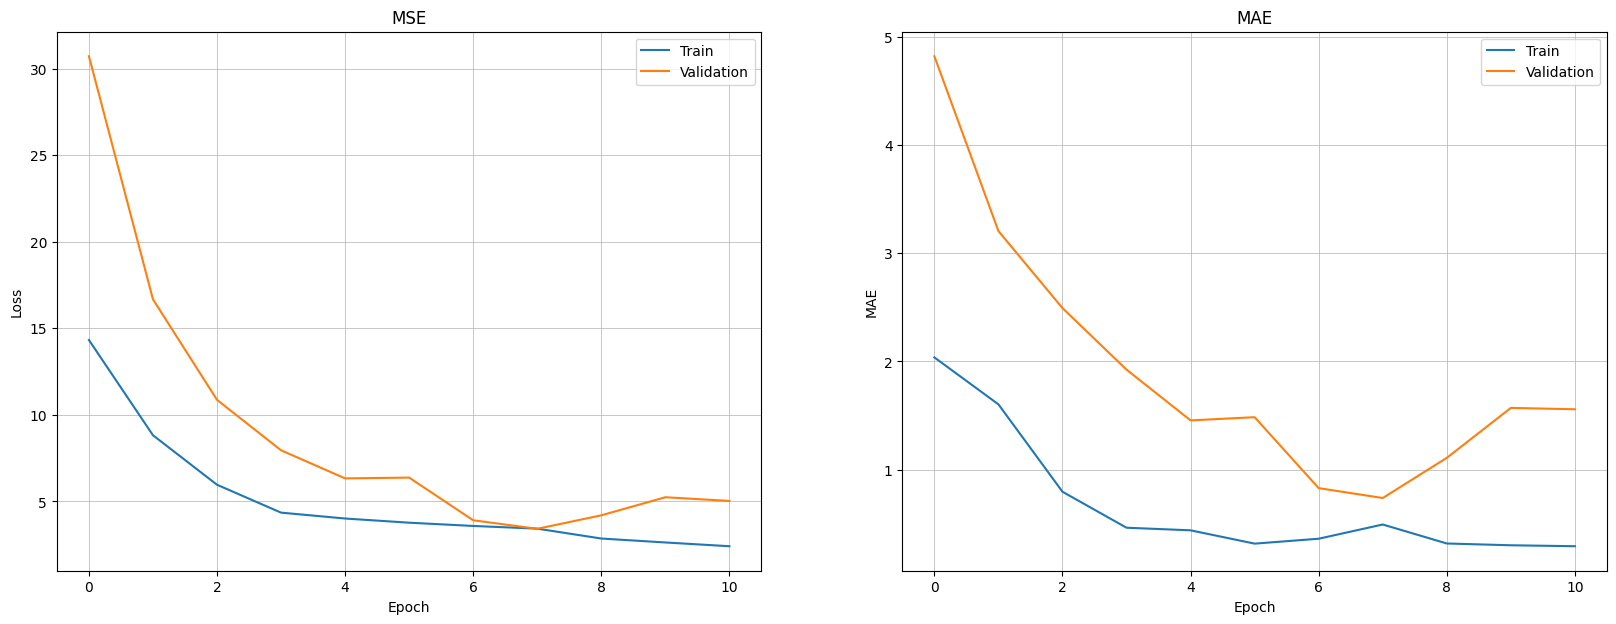

In [59]:
plot_history(history);

In [78]:
# 3 - Evaluation
# ====================================
res = model.evaluate(X_test, y_test)
print(f"The LSTM MSE on the test set is equal to {res[0]}")

1/1 [==============================] - 0s 48ms/step - loss: 6.0048 - mse: 5.7107
The LSTM MSE on the test set is equal to 6.0047502517700195


## (2.2) 💻 A Baseline Model to compare our LSTM with!

👉 In Time Series, an "intuitive" baseline model is to predict the **last seen value** for the future value(s) you want to forecast, as illustrated down below!

<img src = "https://github.com/lewagon/data-images/blob/master/DL/rnn_time_series_no_horizon.png?raw=true" width = 600, height = 300>

💻 ❓ **Question (Last Seen Value Baseline Model)** ❓ 

Create a new method `init_baseline` that initializes and compiles a baseline model in a similar way to the LSTM.

- The baseline should be as a [📚 Keras Lambda Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda)
- It should not even need a `fit` because it should have 0 trainable params
- Then, compute the MAE for this FOLD and compare it with the MAE you obtained on the test set after training the LSTM 
 
<details>
    <summary markdown='span'>💡 <i>Hint</i></summary>

- Remember that `X_train[:,:,1]` is your temperature time-series (it's the second column in your `fold`) 
</details>


In [79]:
from tensorflow.keras.layers import Lambda

def init_baseline():

    # $CHALLENGIFY_BEGIN
    model = models.Sequential()
    model.add(layers.Lambda(lambda x: x[:,-1,1,None]))

    adam = optimizers.Adam(learning_rate=0.02)
    model.compile(loss='mse', optimizer=adam, metrics=["mae"])

    return model


In [80]:
baseline_model = init_baseline()
baseline_score = baseline_model.evaluate(X_test, y_test)
print(f"- The Baseline MAE on the test set is equal to {round(baseline_score[1],2)} Celsius degrees")

1/1 [==============================] - 0s 203ms/step - loss: 0.2376 - mae: 0.4127
- The Baseline MAE on the test set is equal to 0.41 Celsius degrees


In [81]:
print(f"- The LSTM MAE on the test set is equal to {round(res[1],2)} Celsius degrees")
print(f"🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : {round((1 - (res[1]/baseline_score[1]))*100,2)} % 🔥")

- The LSTM MAE on the test set is equal to 5.71 Celsius degrees
🔥 Improvement of the LSTM model over the baseline (on this fold for the test set) = : -1283.67 % 🔥


## (2.3) 💻 Cross-Validation

Remember **"The big picture"** ? 

<br>

<details>
    <summary markdown='span'><i>The big picture</i></summary>


<b><u>Step 1: Cross-Validation in Time Series [FOLDS] </u></b>

* Starting from this single Time Series, we will create <font color="#c91ac9">**FOLDS**</font>...
* ... and train/evaluate our LSTM on these different <font color="#c91ac9">**FOLDS**</font> to conclude about the robustness of the neural network
* It is very common to create ***hundreds*** of <font color="#c91ac9">**FOLDS**</font> in Time Series forecasting, so as to cover all type of external conditions: e.g.
    - crash market periods 📉
    - bull markets 📈
    - atone markets 😴, etc...

<b><u>Step 2: Holdout method within each fold [TRAIN-TEST SPLIT]</u></b>

* For each <font color="#c91ac9">**FOLD**</font>, we will do a TRAIN-TEST SPLIT to:
    * <font color=blue>**fit**</font> the model on the <font color=blue>**train**</font> set 
    * and <font color="#ff8005">**evaluate**</font> it on the <font color="#ff8005">**test**</font> set
    * Always split the train set **chronologically** before the test set!

👇 The first two steps can be summarized in the following image that contains 4 FOLDS:

<img src="https://bit.ly/3yLoa92" alt="Time Series Cross Validation" width="500" height="500">


<b><u>Step 3: Sampling SEQUENCES in both the train set and the test set</u></b>

In each <font color=blue>**train**</font> set and each <font color="#ff8005">**test**</font> set, we will create <font color=magenta>**random sequences**</font> as illustrated down below 👇:

<img src="https://bit.ly/3Ri8Vfd" alt="Sequences in each fold" width="500" height="500"> 


</details>

❗️ ***Warnings*** ❗️

* Keep in mind that we did <u><i>step 2</i></u> (<font color="blue">train</font>/<font color="orange">test</font> split) and <u><i>step 3</i></u> (get_X_y) only **<font color="#c91ac9">for one single FOLD</font>**. 
* ***If we want to ensure the robustness of a model, we need to <font color="">cross-validate the model on <font color="#c91ac9">ALL the folds</font>!***


In [82]:
# Reminders of the global variables in this notebook

print(f'N_FEATURES = {N_FEATURES}') 
print(f'N_TARGETS = {N_TARGETS}') 
print('')
print(f'FOLD_LENGTH = {FOLD_LENGTH}')
print(f'FOLD_STRIDE = {FOLD_STRIDE}')
print(f'TRAIN_TEST_RATIO = {TRAIN_TEST_RATIO}')
print('')
print(f'N_TRAIN = {N_TRAIN}')
print(f'N_TEST = {N_TEST}')
print(f'INPUT_LENGTH = {INPUT_LENGTH}')
print(f'OUTPUT_LENGTH = {OUTPUT_LENGTH}')


N_FEATURES = 7
N_TARGETS = 1

FOLD_LENGTH = 120
FOLD_STRIDE = 40
TRAIN_TEST_RATIO = 0.8

N_TRAIN = 80
N_TEST = 20
INPUT_LENGTH = 30
OUTPUT_LENGTH = 1


In [83]:
# Remember how many folds do we have ?
folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)

print(f"WARNING, we have {len(folds)} FOLDS, so you may want to run the cross-validation of the RNN on Colab.")

WARNING, we have 16 FOLDS, so you may want to run the cross-validation of the RNN on Colab.


💻 **❓ Cross validate your baseline and your model in a for-loop!❓**

Re-using your previously defined methods
- `get_folds`
- `train_test_split`
- `get_X_y`
- `init_model`
- `init_baseline`

In [84]:
from tensorflow.keras.callbacks import EarlyStopping

def cross_validate_baseline_and_lstm():
    '''
    This function cross-validates 
    - the "last seen value" baseline model
    - the RNN model
    '''
    
    list_of_mae_baseline_model = []
    list_of_mae_recurrent_model = []
    
    # 0 - Creating folds
    # =========================================    
    folds = get_folds(df, FOLD_LENGTH, FOLD_STRIDE)
    
    for fold_id, fold in enumerate(folds):
        
        # 1 - Train/Test split the current fold
        # =========================================
        (fold_train, fold_test) = train_test_split(fold, TRAIN_TEST_RATIO, INPUT_LENGTH)                   

        X_train, y_train = get_X_y(fold_train, N_TRAIN, INPUT_LENGTH, OUTPUT_LENGTH)
        X_test, y_test = get_X_y(fold_test, N_TEST, INPUT_LENGTH, OUTPUT_LENGTH)
        
        # 2 - Modelling
        # =========================================
        
        ##### Baseline Model
        baseline_model = init_baseline()
        mae_baseline = baseline_model.evaluate(X_test, y_test, verbose=0)[1]
        list_of_mae_baseline_model.append(mae_baseline)
        print("-"*50)
        print(f"MAE baseline fold n°{fold_id} = {round(mae_baseline, 2)}")

        ##### LSTM Model
        model = init_model(X_train, y_train)
        es = EarlyStopping(monitor = "val_mae",
                           mode = "min",
                           patience = 2, 
                           restore_best_weights = True)
        history = model.fit(X_train, y_train,
                            validation_split = 0.3,
                            shuffle = False,
                            batch_size = 32,
                            epochs = 50,
                            callbacks = [es],
                            verbose = 0)
        res = model.evaluate(X_test, y_test, verbose=0)
        mae_lstm = res[1]
        list_of_mae_recurrent_model.append(mae_lstm)
        print(f"MAE LSTM fold n°{fold_id} = {round(mae_lstm, 2)}")
        
        ##### Comparison LSTM vs Baseline for the current fold
        print(f"🏋🏽‍♂️ improvement over baseline: {round((1 - (mae_lstm/mae_baseline))*100,2)} % \n")

    return list_of_mae_baseline_model, list_of_mae_recurrent_model

In [85]:
%%time
# WARNING : it takes 75 minutes to run this cell 
mae_baselines, mae_lstms = cross_validate_baseline_and_lstm()

--------------------------------------------------
MAE baseline fold n°0 = 0.44
MAE LSTM fold n°0 = 0.64
🏋🏽‍♂️ improvement over baseline: -45.0 % 

--------------------------------------------------
MAE baseline fold n°1 = 2.15


MAE LSTM fold n°1 = 3.37
🏋🏽‍♂️ improvement over baseline: -56.71 % 

--------------------------------------------------
MAE baseline fold n°2 = 0.6


MAE LSTM fold n°2 = 1.52
🏋🏽‍♂️ improvement over baseline: -153.17 % 

--------------------------------------------------
MAE baseline fold n°3 = 1.31


MAE LSTM fold n°3 = 9.37
🏋🏽‍♂️ improvement over baseline: -616.71 % 

--------------------------------------------------
MAE baseline fold n°4 = 0.74


MAE LSTM fold n°4 = 9.77
🏋🏽‍♂️ improvement over baseline: -1220.2 % 

--------------------------------------------------
MAE baseline fold n°5 = 1.32


MAE LSTM fold n°5 = 0.71
🏋🏽‍♂️ improvement over baseline: 46.24 % 

--------------------------------------------------
MAE baseline fold n°6 = 0.34


MAE LSTM fold n°6 = 0.67
🏋🏽‍♂️ improvement over baseline: -96.66 % 

--------------------------------------------------
MAE baseline fold n°7 = 0.35
MAE LSTM fold n°7 = 0.48
🏋🏽‍♂️ improvement over baseline: -35.85 % 

--------------------------------------------------
MAE baseline fold n°8 = 0.35


MAE LSTM fold n°8 = 3.26
🏋🏽‍♂️ improvement over baseline: -836.87 % 

--------------------------------------------------
MAE baseline fold n°9 = 0.59


MAE LSTM fold n°9 = 0.23
🏋🏽‍♂️ improvement over baseline: 61.4 % 

--------------------------------------------------
MAE baseline fold n°10 = 0.83


MAE LSTM fold n°10 = 0.58
🏋🏽‍♂️ improvement over baseline: 29.75 % 

--------------------------------------------------
MAE baseline fold n°11 = 1.06


MAE LSTM fold n°11 = 0.28
🏋🏽‍♂️ improvement over baseline: 73.82 % 

--------------------------------------------------
MAE baseline fold n°12 = 1.54


MAE LSTM fold n°12 = 0.25
🏋🏽‍♂️ improvement over baseline: 83.45 % 

--------------------------------------------------
MAE baseline fold n°13 = 0.22


MAE LSTM fold n°13 = 0.03
🏋🏽‍♂️ improvement over baseline: 86.57 % 

--------------------------------------------------
MAE baseline fold n°14 = 1.1
MAE LSTM fold n°14 = 0.46
🏋🏽‍♂️ improvement over baseline: 58.47 % 

--------------------------------------------------
MAE baseline fold n°15 = 0.37


MAE LSTM fold n°15 = 0.02
🏋🏽‍♂️ improvement over baseline: 93.9 % 

CPU times: user 2min 16s, sys: 8.98 s, total: 2min 25s
Wall time: 2min 1s


In [86]:
print(f"average percentage improvement over baseline = {round(np.mean(1 - (np.array(mae_lstms)/np.array(mae_baselines))),2)*100}%")

average percentage improvement over baseline = -158.0%


## Acknowledgments

* This challenge was truly inspired by the `Time Series Forecasting` tutorial from `Google>Tensorflow>Keras`
* The technical functions were inspired by Bruno Lajoie's [data-template package about Time Series](https://github.com/lewagon/data-templates/tree/main/project-boilerplates)

# (Bonus) The original dataset 

🥋 If you want to practice your feature engineering skills, feel free to come back to this challenge later, download the original dataset and work on it.

In [ ]:
#########################################################
# Uncomment later -not today- to download the original  #
# dataset and try to perform the features engineering   #
# by yourself                                           #
#########################################################


zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

raw = pd.read_csv(csv_path)

print(f"raw.shape = {raw.shape}")
display(raw.head())

In [ ]:
# Inspecting each feature to detect their type and null values
raw.info()

In [ ]:
# Slice [start:stop:step], 
# starting from index 5, take every 6th record
# to get only hourly records

# $CHALLENGIFY_BEGIN
df = raw[5::6].copy()
df.head()
# $CHALLENGIFY_END

In [ ]:
# Convert the "Date Time" column to a datetime format

# $CHALLENGIFY_BEGIN
df["Date Time"] = pd.to_datetime(df["Date Time"])
# $CHALLENGIFY_END

In [ ]:
# Describe the dataset

# $CHALLENGIFY_BEGIN
round(df.describe().transpose(),2)
# $CHALLENGIFY_END

In [ ]:
## Fixing the wv, look at the absurd values and replace them with zero

# $CHALLENGIFY_BEGIN
wv = df['wv (m/s)']
bad_wv = (wv == -9999.0)
df.loc[bad_wv, 'wv (m/s)'] = 0.0
# $CHALLENGIFY_END

## Fixing the max wv

# $CHALLENGIFY_BEGIN
max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
df.loc[bad_max_wv, 'max. wv (m/s)'] = 0.0
# $CHALLENGIFY_END

In [ ]:
# Wind : Wd degrees from 0 to 360 egrees
# Angles do not make good models inputs because 0 and 360 should be "close"

print('-'*50)
print("Working with angles...")

plt.hist2d(df['wd (deg)'], df['wv (m/s)'], 
           bins=(50, 50), 
           vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')
plt.show()

# It is much easier for the model to interpret
# the wind direction and the wind velocity through a vector


# Convert degrees to radians and store the values into wd_rad
# $CHALLENGIFY_BEGIN
wd_rad = df.pop('wd (deg)')*np.pi / 180
# $CHALLENGIFY_END

# Calculate the wind x and y components and store then in two new columns
# `Wx` and `Wy`
# $CHALLENGIFY_BEGIN
wv = df.pop('wv (m/s)')
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)
# $CHALLENGIFY_END

# Calculate the max wind x and y components and store then in two new columns
# `max Wx` and `max Wy`
# $CHALLENGIFY_BEGIN
max_wv = df.pop('max. wv (m/s)')
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)
# $CHALLENGIFY_END

print('-'*50)
print("Working with wind vectors")

plt.hist2d(df['Wx'], df['Wy'], 
           bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')
plt.show()

# $CHALLENGIFY_END

In [ ]:
# Similarly to the wind direction, the time in seconds is not a useful model input
# The weather dataset has clear daily and yearly periodicities
# Using sine and cosine functions, we can compute:
# - the time of the day
# - the time of the year

# $CHALLENGIFY_BEGIN

# Collecting the timestamps
datetime_df = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamps_s = datetime_df.map(pd.Timestamp.timestamp)
timestamps_s

# 24 hours x 60 minutes/hour x 60 seconds/minute
day = 24*60*60 
# 1 year in days
year = (365.2425)*day

# Day periodicity
df['Day_sin'] = np.sin(timestamps_s * (2 * np.pi / day))
df['Day_cos'] = np.cos(timestamps_s * (2 * np.pi / day))

# Year periodicity
df['Year_sin'] = np.sin(timestamps_s * (2 * np.pi / year))
df['Year_cos'] = np.cos(timestamps_s * (2 * np.pi / year))

# $CHALLENGIFY_END

In [ ]:
# Select every 3 hours 

# $CHALLENGIFY_BEGIN
df = df[2::3].reset_index(drop = True)
df
# $CHALLENGIFY_END